# Generate cutting XML from exported results from QUPath

The stitched images were loaded into Qupath and specific regions annotaed by hand. calibration points were also selected and labelled with `calib1`, `calib2` and `calib3`.

![QuPath manual shape annotation](./test_data/cellculture_example/qupath_annotation.png "Qupath Manual shape annotation")

The annotated shapes were then exported to geojson file.

![Geojson export](./test_data/cellculture_example/qupath_export_1.png "GEOjson export")
![Geojson export](./test_data/cellculture_example/geojson_export_2.png "GEOjson export")


## Import libraries and define helper functions

In [1]:
# import required libraries
import json
import geojson 
import geopandas
import pandas as pd
import numpy as np

from lmd.lib import Collection, Shape

In [2]:
#define helper functions

def get_calib_points(list_of_calibpoint_names, df):
    #create shape list
    pointlist = []
    for point_name in list_of_calibpoint_names:
        pointlist.append(df.loc[df['name'] == point_name, 'geometry'].values[0])
    
    #create coordinate list
    listarray = []
    for point in pointlist:
        listarray.append([point.x, point.y])
    nparray = np.array(listarray)
    
    return(nparray)

#returns dataframe with only polygon objects
def remove_non_polygons(df):
    import shapely
    
    df_filtered = df.loc[[type(x) == shapely.geometry.polygon.Polygon for x in df.geometry]]
    return(df_filtered)

#creates new column for coordenates in a list of list format
#assumes only polygons in dataframe
def replace_coords(df):
    df['coordinates_shape_exterior'] = np.nan
    df['coordinates_shape_exterior'] = df['coordinates_shape_exterior'].astype('object')
    
    for i in df.index:
        #get geometry object for row i
        geom = df.at[i, 'geometry']
        #list the coordinate points as tuples
        tmp = list(geom.exterior.coords)
        #transform list of tuples to list of lists and save to dataframe
        df.at[i,'coordinates_shape_exterior'] = [list(i) for i in tmp]
    
    return(df)


## Import GEOjson regions

The geojson dataset is loaded into a dataframe with the following structure:

id                     objectType                          classification                              name                       geometry
unique shape id        type of shape (e.g. annotation)     all annotation information from qupath      shape name if given        contains information relevant for shape

The geojson should besides containing individual segemnted shapes contain 3 points annotated as calib1, calib2, calib3 that will be used as calibration points for generating the XML

In [3]:
df = geopandas.read_file("test_data/cellculture_example/annotated_regions_Qupath.geojson")
df

,id,objectType,name,geometry
0,9287277d-e46f-47e9-aa3f-c540b3318b5e,annotation,region2,"POLYGON ((507.00000 1524.00000, 506.60000 1539..."
1,ab63cfd3-17d0-4dd3-b8e6-95172dda64de,annotation,Region1,"POLYGON ((1789.00000 990.00000, 1730.00000 115..."
2,b60d2cf7-963e-42ae-8a2a-69ff289d29db,annotation,calib1,POINT (343.24000 368.53000)
3,56bdd076-ac9a-4950-97f3-b8c2268ee090,annotation,calib3,POINT (361.78000 2301.51000)
4,03d9bb6e-16b1-4cd9-9181-86da90fb98bf,annotation,calib2,POINT (1353.77000 1165.83000)


## Calibration points

In [4]:
#assumes user will always label their calibration points like this 
caliblist = get_calib_points(['calib1','calib2','calib3'],df)
print(caliblist)

[[ 343.24  368.53]
 [1353.77 1165.83]
 [ 361.78 2301.51]]


## Clean up Dataframe

Remove non-polygon shapes, extract polygon coordinates, and parse annotation for easier use

In [5]:
df_poly = remove_non_polygons(df)
df_poly = replace_coords(df_poly)
df_poly

/Users/sophia/mambaforge/envs/SPARCSpy/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/sophia/mambaforge/envs/SPARCSpy/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,id,objectType,name,geometry,coordinates_shape_exterior
0,9287277d-e46f-47e9-aa3f-c540b3318b5e,annotation,region2,"POLYGON ((507.00000 1524.00000, 506.60000 1539...","[[507.0, 1524.0], [506.6, 1539.01], [505.39, 1..."
1,ab63cfd3-17d0-4dd3-b8e6-95172dda64de,annotation,Region1,"POLYGON ((1789.00000 990.00000, 1730.00000 115...","[[1789.0, 990.0], [1730.0, 1153.0], [1744.0, 1..."


## Generate shape collection

In [10]:
shape_collection = Collection(calibration_points = caliblist)
shape_collection.orientation_transform = np.array([[1,0 ], [0,-1]])

In [11]:
for i in df_poly.index:
    shape_collection.new_shape(df_poly.loc[i,'coordinates_shape_exterior'], well = "well1") # can define a well if so wished otherwise leave out

===== Collection Stats =====
Number of shapes: 2
Number of vertices: 117
Mean vertices: 58
Min vertices: 16
5% percentile vertices: 20
Median vertices: 58
95% percentile vertices: 97
Max vertices: 101
None


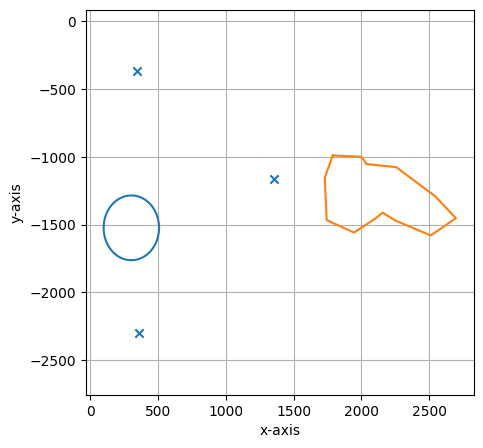

In [12]:
#print some statistics on the shapes included in the collection and visualize results
print(shape_collection.stats())
shape_collection.plot(calibration = True)

## write to XML

In [13]:
shape_collection.save("./test_data/cellculture_example/shapes_2.xml")

[ 34324. -36853.]
[ 135377. -116583.]
[  36178. -230151.]
